In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

Epoch 1/150


c:\Users\allan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1123 - val_loss: 0.0019
Epoch 2/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 4.5193e-05
Epoch 3/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0560e-04 - val_loss: 4.0945e-05
Epoch 4/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6804e-04 - val_loss: 5.3491e-05
Epoch 5/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1883e-04 - val_loss: 6.9990e-05
Epoch 6/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5505e-04 - val_loss: 3.6784e-05
Epoch 7/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8475e-04 - val_loss: 1.0655e-04
Epoch 8/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2444e-04 - val_loss: 6.8267e-05
Epoch 9/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9213e-04 - val_loss: 3.8162e-05
Epoch 10/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7849e-04 - val_loss: 4.2823e-05
Epoch 11/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8503e-04 - val_loss: 7.3078e-0

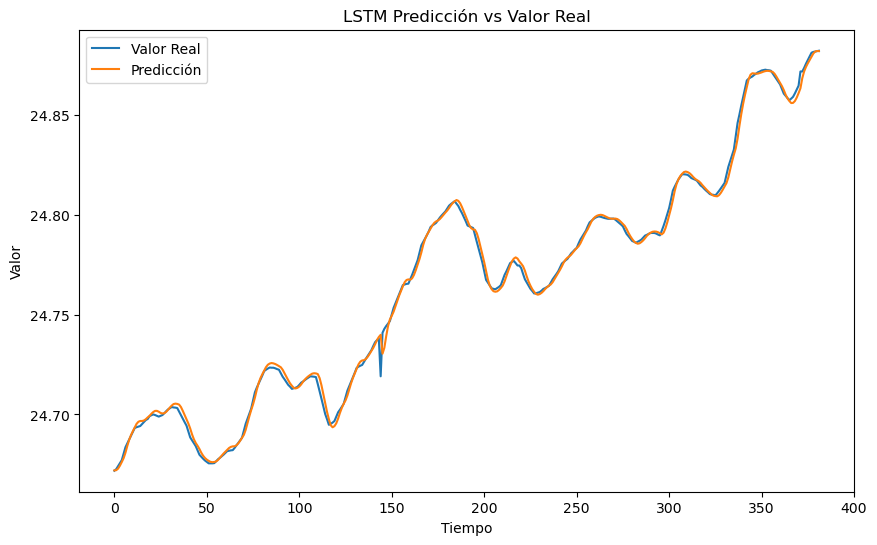

In [12]:
url = 'https://bchapi-am.azure-api.net/api/v1/indicadores/620/cifras?formato=Json&fechaInicio=2017-01-01&ordenamiento=asc&clave=04d1c14361564cbfa78b0c37eb2398af'

response = requests.get(url)
fechas = []
valores = []

if response.status_code == 200:
    data = response.json()
    for entry in data:
        fecha = entry['Fecha']
        valor = entry['Valor']
        fechas.append(datetime.strptime(fecha, '%Y-%m-%dT%H:%M:%S'))
        valores.append(valor)

    # Normalizar los datos
    valores = np.array(valores).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    valores_normalizados = scaler.fit_transform(valores)

    # Convertir los datos en secuencias para LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 10
    X, y = create_sequences(valores_normalizados, seq_length)

    # Redimensionar datos para ajustarse al modelo LSTM
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Dividir en datos de entrenamiento y prueba
    train_size = int(X.shape[0] * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

    # Predecir en los datos de prueba
    y_pred = model.predict(X_test)

    # Inversión de la normalización en las predicciones y valores reales
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Gráfica de las predicciones versus los valores reales
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label='Valor Real')
    plt.plot(y_pred_inv, label='Predicción')
    plt.title('LSTM Predicción vs Valor Real')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

else:
    print("Error al obtener los datos:", response.status_code)

In [13]:
model.save('mi_modelo.h5')

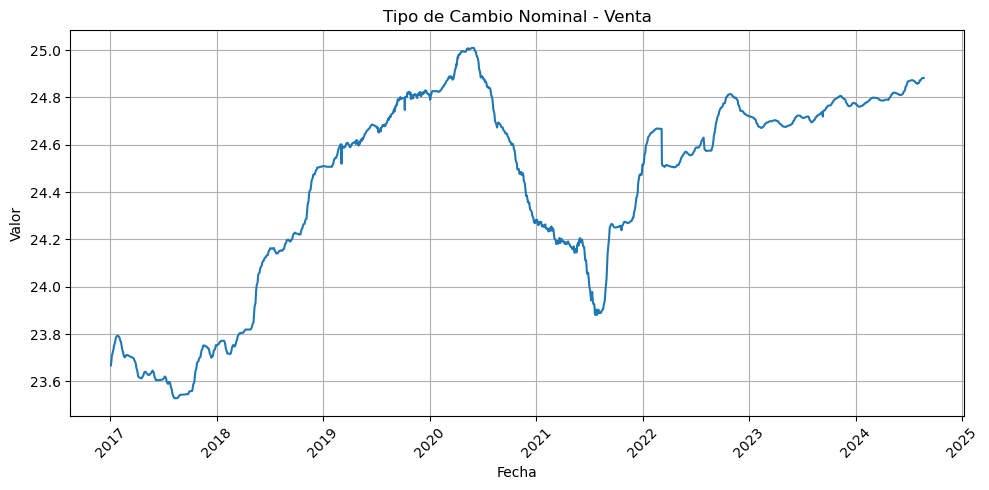

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(fechas, valores)
plt.title('Tipo de Cambio Nominal - Venta')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [ ]:
# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual Value')
plt.plot(y_pred_inv, label='Predicted Value')
plt.title('LSTM Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import get_custom_objects
import tensorflow as tf

In [29]:
@tf.keras.utils.register_keras_serializable()
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)


model = load_model('mi_modelo.h5', compile=False)

model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
url = 'https://bchapi-am.azure-api.net/api/v1/indicadores/620/cifras?formato=Json&fechaInicio=2017-01-01&ordenamiento=asc&clave=04d1c14361564cbfa78b0c37eb2398af'

# Realizar la solicitud GET a la API
response = requests.get(url)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    data = response.json()
    
    # Extraer las fechas y los valores del JSON
    fechas = []
    valores = []

    for entry in data:
        fechas.append(entry['Fecha'])
        valores.append(entry['Valor'])

    # Crear un DataFrame con los datos
    df = pd.DataFrame({
        'Fecha': fechas,
        'Valor': valores
    })

    # Guardar el DataFrame en un archivo CSV
    df.to_csv('datos_tipo_cambio.csv', index=False)

    print("Datos guardados en 'datos_tipo_cambio.csv'")
else:
    print("Error al obtener los datos:", response.status_code)

Datos guardados en 'datos_tipo_cambio.csv'
